In [ ]:
!pip install -f -e "fastai[dev]"

In [1]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 197 kB 9.1 MB/s 
     |████████████████████████████████| 59 kB 9.1 MB/s 


## Unzip the dataset folder

## NSFW Image Classification

In [2]:
from google.colab import drive, files

In [3]:
from __future__ import annotations
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.vision.core import *
from fastai import *
import types

In [4]:
!unzip /content/drive/MyDrive/Datasets/kaggle/archive.zip -d nsfw_image_classification

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: nsfw_image_classification/val/porn/46929.jpg  
  inflating: nsfw_image_classification/val/porn/46930.jpg  
  inflating: nsfw_image_classification/val/porn/46937.jpg  
  inflating: nsfw_image_classification/val/porn/46946.jpg  
  inflating: nsfw_image_classification/val/porn/46949.jpg  
  inflating: nsfw_image_classification/val/porn/46950.jpg  
  inflating: nsfw_image_classification/val/porn/46972.jpg  
  inflating: nsfw_image_classification/val/porn/46984.jpg  
  inflating: nsfw_image_classification/val/porn/46987.jpg  
  inflating: nsfw_image_classification/val/porn/46989.jpg  
  inflating: nsfw_image_classification/val/porn/46994.jpg  
  inflating: nsfw_image_classification/val/porn/47006.jpg  
  inflating: nsfw_image_classification/val/porn/47007.jpg  
  inflating: nsfw_image_classification/val/porn/47027.jpg  
  inflating: nsfw_image_classification/val/porn/47035.jpg  
  inflating: nsfw_imag

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

In [6]:
lbl_dict = dict(
    neutral="neutral",
    porn="porn",
    hentai="hentai",
    sexy="sexy",
    drawing="drawing"
)

In [7]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [8]:
nsfw_images = Path("./nsfw_image_classification/")

In [9]:
dls = ImageDataLoaders.from_folder(
    nsfw_images,
    valid='val', 
    bs=64,
    item_tfms=RandomResizedCrop(128, min_scale=0.35), 
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

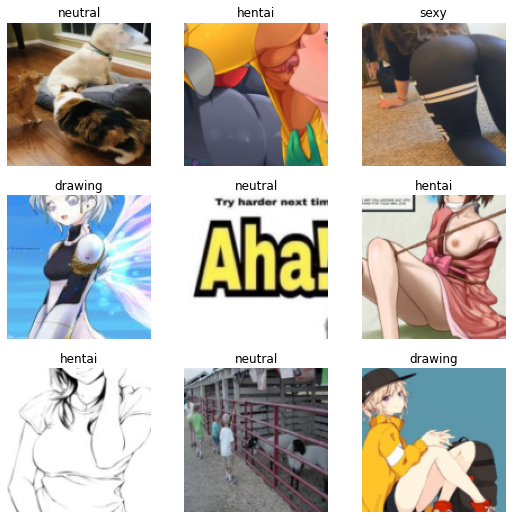

In [10]:
dls.show_batch()

## Convert filenames to class

In [11]:
fnames = get_image_files(nsfw_images)

In [12]:
parent_label(fnames[0])

'sexy'

In [13]:
dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
    splitter = GrandparentSplitter(valid_name='val'),
    item_tfms = RandomResizedCrop(128, min_scale=0.35),
    batch_tfms = Normalize.from_stats(*imagenet_stats)
)

nsfw_datasets = dblock.datasets(nsfw_images)
nsfw_datasets.train[0]

(PILImage mode=RGB size=224x224, TensorCategory(4))

In [14]:
nsfw_datasets.vocab

['drawing', 'hentai', 'neutral', 'porn', 'sexy']

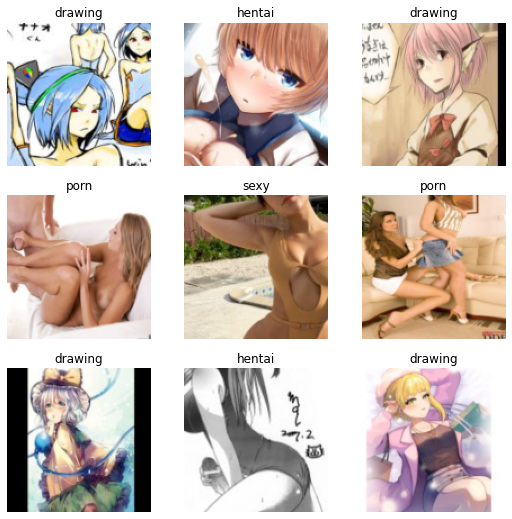

In [15]:
dls_nsfw_datasets = dblock.dataloaders(nsfw_images)
dls_nsfw_datasets.show_batch()

## Training 

In [16]:
learn = vision_learner(
    dls_nsfw_datasets, 
    resnet34, 
    metrics=accuracy,
    pretrained=False
)

SuggestedLRs(valley=0.0008317637839354575)

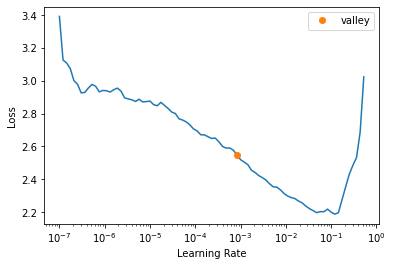

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(3,5e-3)
learn.unfreeze()
learn.fit_one_cycle(5,lr_max=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.679793,0.597801,0.781104,14:20
1,0.492728,0.452802,0.837947,13:46
2,0.418345,0.350222,0.876581,13:42


epoch,train_loss,valid_loss,accuracy,time
0,0.421235,0.352159,0.875863,13:36
1,0.414046,0.349607,0.876860,13:34
2,0.407619,0.345613,0.877757,13:34
3,0.393468,0.345152,0.878156,13:30
4,0.405530,0.345164,0.877259,13:35


In [19]:
learn.save("./nsfw_image_classification.pkl")

Path('models/nsfw_image_classification.pkl.pth')

In [20]:
!cp /content/models/nsfw_image_classification.pkl.pth ./drive/MyDrive/Datasets/kaggle/nsfw_image_classification/

In [ ]:
learn.export(Path('./nsfw_image_classification.pkl'))

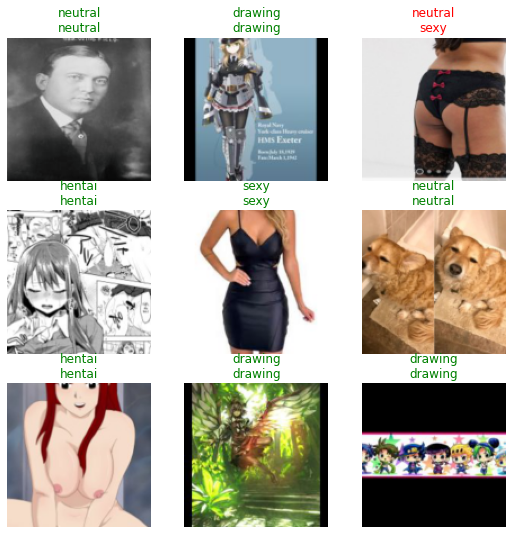

In [21]:
learn.show_results()

In [27]:
def plot_top_losses_debug(interp,idx, k=9, largest=True, **kwargs):
    if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
    if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
    else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
    k=9
    b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
    x,y,its = interp.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
    x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
    if its is not None:
        plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses, figsize=(20,20))

In [22]:
interpretation = ClassificationInterpretation.from_learner(learn)
losses, idx = interpretation.top_losses()

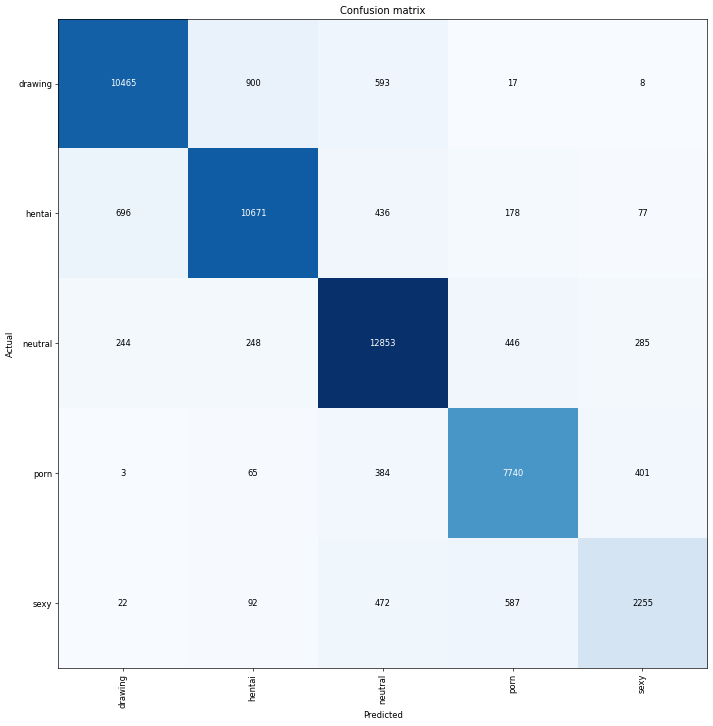

In [23]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

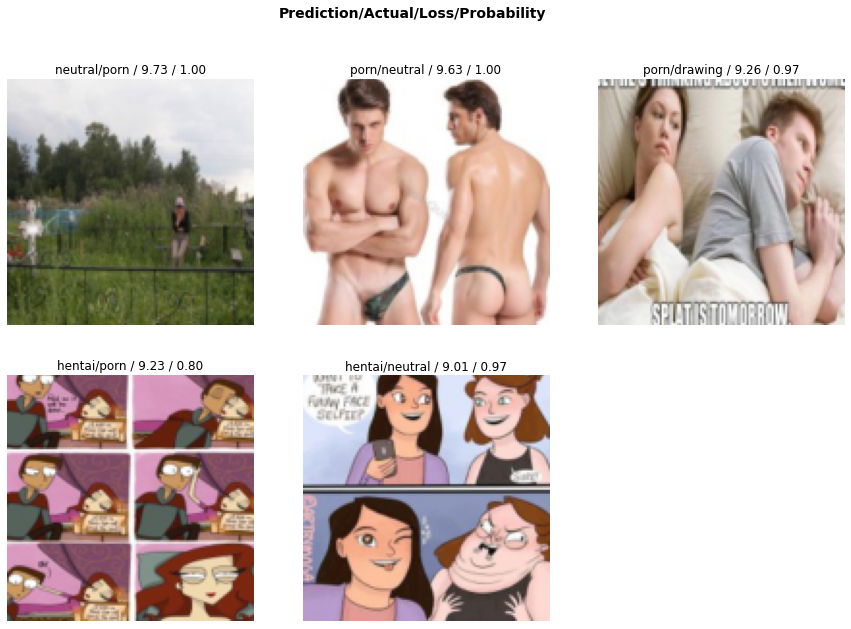

In [32]:
interpretation.plot_top_losses(5, figsize=(15,10))

In [26]:
interpretation.most_confused(min_val=2)

[('drawing', 'hentai', 900),
 ('hentai', 'drawing', 696),
 ('drawing', 'neutral', 593),
 ('sexy', 'porn', 587),
 ('sexy', 'neutral', 472),
 ('neutral', 'porn', 446),
 ('hentai', 'neutral', 436),
 ('porn', 'sexy', 401),
 ('porn', 'neutral', 384),
 ('neutral', 'sexy', 285),
 ('neutral', 'hentai', 248),
 ('neutral', 'drawing', 244),
 ('hentai', 'porn', 178),
 ('sexy', 'hentai', 92),
 ('hentai', 'sexy', 77),
 ('porn', 'hentai', 65),
 ('sexy', 'drawing', 22),
 ('drawing', 'porn', 17),
 ('drawing', 'sexy', 8),
 ('porn', 'drawing', 3)]

In [30]:
learn.predict(fnames[0])

('neutral',
 TensorBase(2),
 TensorBase([0.0045, 0.0016, 0.7062, 0.0294, 0.2583]))

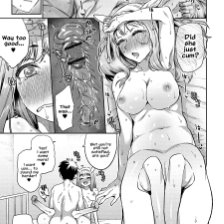

In [44]:
Image.open(fnames[19999])


In [45]:
learn.predict(fnames[19999])

('hentai',
 TensorBase(1),
 TensorBase([1.0880e-03, 9.9887e-01, 3.5575e-05, 4.5902e-06, 3.9167e-06]))